In [7]:
import os
import glob

import trimesh
from plyfile import PlyData, PlyElement
import open3d as o3d

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [5]:
mesh = trimesh.load('../data/paris_lille/mesh_objects/mesh_302020400_580.ply')
mesh.show()

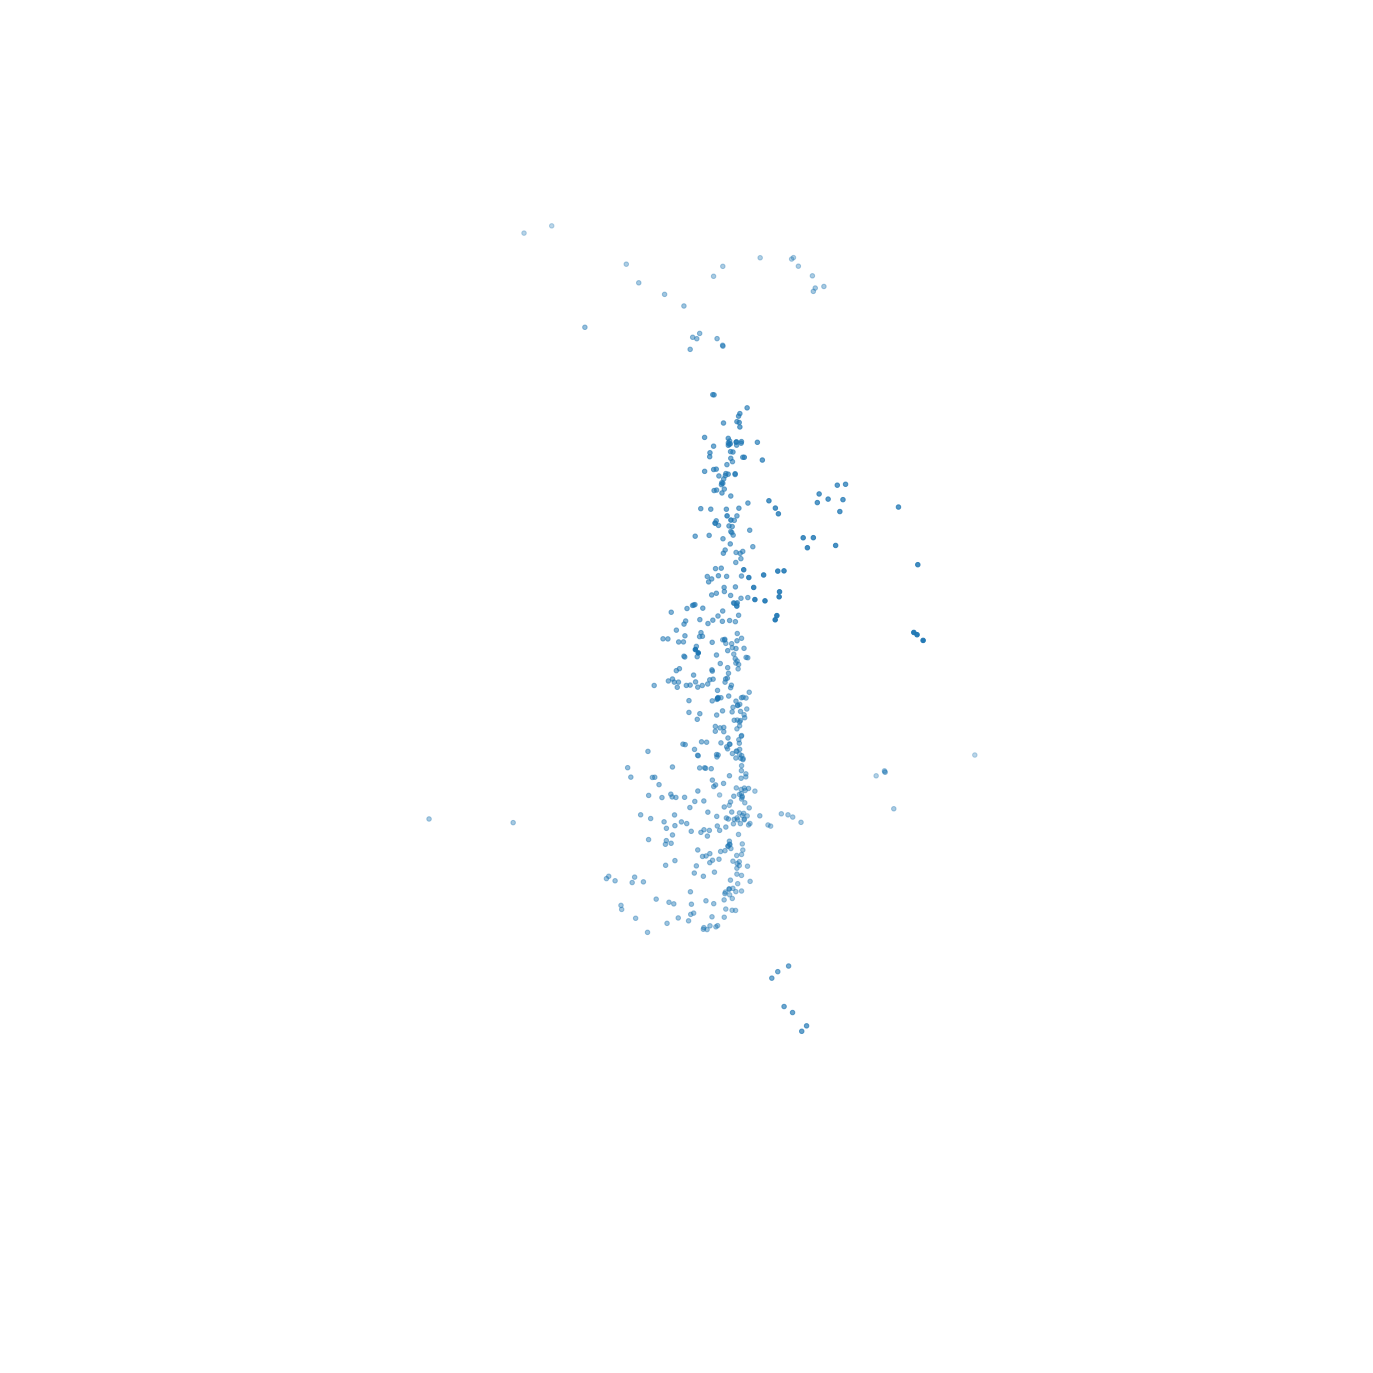

In [8]:
points = mesh.sample(500)

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:,0], points[:,1], points[:,2])
ax.set_axis_off()
plt.show()

In [148]:
#points = []
#labels = []

#for file in glob.glob('../data/paris_lille/mesh_objects/*.ply'):
#    mesh = trimesh.load(file)
#    pcd = mesh.sample(1000)
    
#    label = file.split('/')[-1].split('_')[1]
    
#    points.append(pcd)
#    labels.append(label)

In [27]:
points = []
labels = []

for file in glob.glob('../data/paris_lille/sampled_ply/*.ply'):
    
    label = file.split('/')[-1].split('_')[1]
    
    ply = PlyData.read(file)
    data = ply.elements[0].data
    data_pd = pd.DataFrame(data)
    data_np = np.zeros(data_pd.shape, dtype=np.float)
    property_names = data[0].dtype.names
    
    for i, name in enumerate(property_names):
        data_np[:,i] = data_pd[name]
        
    data_np = data_np[:,:3]    
    data_np = preprocessing.minmax_scale(data_np)
    
    points.append(data_np)
    labels.append(label)

In [28]:
object_classes = {
    '0' : 'Unclassified',
    '100000000' : 'Other',
    '200000000' : 'Surface',
    '201000000' : 'Other Surface',
    '202000000' : 'Ground',
    '202010000' : 'Other Ground',
    '202020000' : 'Road',
    '202030000' : 'Sidewalk',
    '202040000' : 'Curb',
    '202050000' : 'Island',
    '202060000' : 'Vegetation',
    '203000000' : 'Building',
    '300000000' : 'Object',
    '301000000' : 'Other Object',
    '302000000' : 'Static',
    '302010000' : 'Other Static',
    '302020000' : 'Punctual Object',
    '302020100' : 'Other Punctual Object',
    '302020200' : 'Post',
    '302020300' : 'Bollard',
    '302020400' : 'Floor Lamp',
    '302020500' : 'Traffic Light',
    '302020600' : 'Traffic Sign',
    '302020700' : 'Signboard',
    '302020800' : 'Mailbox',
    '302020900' : 'Trash Can',
    '302021000' : 'Meter',
    '302021100' : 'Bicycle Terminal',
    '302021200' : 'Bicycle Rack',
    '302021300' : 'Statue',
    '302030000' : 'Linear',
    '302030100' : 'Other Linear',
    '302030200' : 'Barrier',
    '302030300' : 'Roasting',
    '302030400' : 'Grid',
    '302030500' : 'Chain',
    '302030600' : 'Wire',
    '302030700' : 'Low Wall',
    '302040000' : 'Extended',
    '302040100' : 'Other Extended',
    '302040200' : 'Shelter',
    '302040300' : 'Kiosk',
    '302040400' : 'Scaffold',
    '302040500' : 'Bench',
    '302040600' : 'Distribution Box',
    '302040700' : 'Lighting Console',
    '302040800' : 'Windmill',
    '303000000' : 'Dynamic',
    '303010000' : 'Other Dynamic',
    '303020000' : 'Pedestrian',
    '303020100' : 'Other Pedestrian',
    '303020200' : 'Still Pedestrian',
    '303020300' : 'Walking Pedestrian',
    '303020400' : 'Running Pedestrian',
    '303020500' : 'Stroller Pedestrian',
    '303020600' : 'Holding Pedesterian',
    '303020700' : 'Leaning Pedestrian',
    '303020800' : 'Skater',
    '303020900' : 'Rollerskater',
    '303021000' : 'Wheelchair',
    '303030000' : '2 Wheelers',
    '303030100' : 'Other 2 Wheels',
    '303030200' : 'Bicycle',
    '303030201' : 'Other Bicycle',
    '303030202' : 'Mobile Bicycle',
    '303030203' : 'Stopped Bicycle',
    '303030204' : 'Parked Bicycle',
    '303030300' : 'Scooter',
    '303030301' : 'Other Scooter',
    '303030302' : 'Mobile Scooter',
    '303030303' : 'Stopped Scooter',
    '303030304' : 'Parked Scooter',
    '303030400' : 'Moped',
    '303030401' : 'Other Moped',
    '303030402' : 'Mobile Moped',
    '303030403' : 'Stopped Moped',
    '303030404' : 'Parked Moped',
    '303030500' : 'Motorbike',
    '303030501' : 'Other Motorbike',
    '303030502' : 'Mobile Motorbike',
    '303030503' : 'Stopped Motorbike',
    '303030504' : 'Parked Motorbike',
    '303040000' : '4+ Wheelers',
    '303040100' : 'Other 4+ Wheelers',
    '303040200' : 'Car',
    '303040201' : 'Other Car',
    '303040202' : 'Mobile Car',
    '303040203' : 'Stopped Car',
    '303040204' : 'Parked Car',
    '303040300' : 'Van',
    '303040301' : 'Other Van',
    '303040302' : 'Mobile Van',
    '303040303' : 'Stopped Van',
    '303040304' : 'Parked Van',
    '303040400' : 'Truck',
    '303040401' : 'Other Truck',
    '303040402' : 'Mobile Truck',
    '303040403' : 'Stopped Truck',
    '303040404' : 'Parked Truck',
    '303040500' : 'Bus',
    '303040501' : 'Other Bus',
    '303040502' : 'Mobile Bus',
    '303040503' : 'Stopped Bus',
    '303040504' : 'Parked Bus',
    '303050000' : 'Furniture',
    '303050100' : 'Other Furniture',
    '303050200' : 'Table',
    '303050300' : 'Chair',
    '303050400' : 'Stool',
    '303050500' : 'Trash Can',
    '303050600' : 'Waste',
    '304000000' : 'Natural',
    '304010000' : 'Other Natural',
    '304020000' : 'Tree',
    '304030000' : 'Bush',
    '304040000' : 'Potted Plant',
    '304050000' : 'Hedge'
}

In [29]:
labels = [object_classes.get(item,item) for item in labels]
unique_labels = np.unique(labels)

mapping = {}
keys = range(len(unique_labels))

for i in keys:
    mapping[i] = unique_labels[i]
    
rev_mapping = dict((v,k) for k,v in mapping.items())
new_labels = [rev_mapping[i] for i in labels]

In [31]:
NUM_POINTS = 1000
NUM_CLASSES = 48
BATCH_SIZE = 32

In [32]:
X_train, X_test, y_train, y_test = train_test_split(points, new_labels, test_size=.33, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15, random_state=0)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [33]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [34]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [35]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [36]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 1000, 32)     128         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 1000, 32)     128         conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 1000, 32)     0           batch_normalization_17[0][0]     
___________________________________________________________________________________________

In [37]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [38]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [39]:
fit = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[earlystopping])

Epoch 1/50
35/35 [==============================] - 29s 582ms/step - loss: 4.7600 - sparse_categorical_accuracy: 0.2162 - val_loss: 4.0876 - val_sparse_categorical_accuracy: 0.3846
Epoch 2/50
35/35 [==============================] - 19s 530ms/step - loss: 3.7260 - sparse_categorical_accuracy: 0.3715 - val_loss: 3.6455 - val_sparse_categorical_accuracy: 0.4564
Epoch 3/50
35/35 [==============================] - 17s 499ms/step - loss: 3.3570 - sparse_categorical_accuracy: 0.4160 - val_loss: 3.4478 - val_sparse_categorical_accuracy: 0.4615
Epoch 4/50
35/35 [==============================] - 18s 508ms/step - loss: 3.1998 - sparse_categorical_accuracy: 0.4705 - val_loss: 3.6739 - val_sparse_categorical_accuracy: 0.4974
Epoch 5/50
35/35 [==============================] - 18s 504ms/step - loss: 2.9735 - sparse_categorical_accuracy: 0.5068 - val_loss: 3.2419 - val_sparse_categorical_accuracy: 0.5385
Epoch 6/50
35/35 [==============================] - 18s 515ms/step - loss: 2.8952 - sparse_cate

In [40]:
pred = model.predict(test_dataset)
pred = np.argmax(pred, axis=1)

In [41]:
print(accuracy_score(y_test, pred))

0.4522691705790297


In [42]:
print(f1_score(y_test, pred, average='macro'))
print(f1_score(y_test, pred, average='micro'))
print(f1_score(y_test, pred, average='weighted'))

0.16147933788547902
0.4522691705790297
0.38697733637442533


# **CONFUSION MATRIX**

In [43]:
rev_rev_mapping = dict((v,k) for k,v in rev_mapping.items())
ytestlabels = [rev_rev_mapping[i] for i in y_test]
predlabels = [rev_rev_mapping[i] for i in pred]

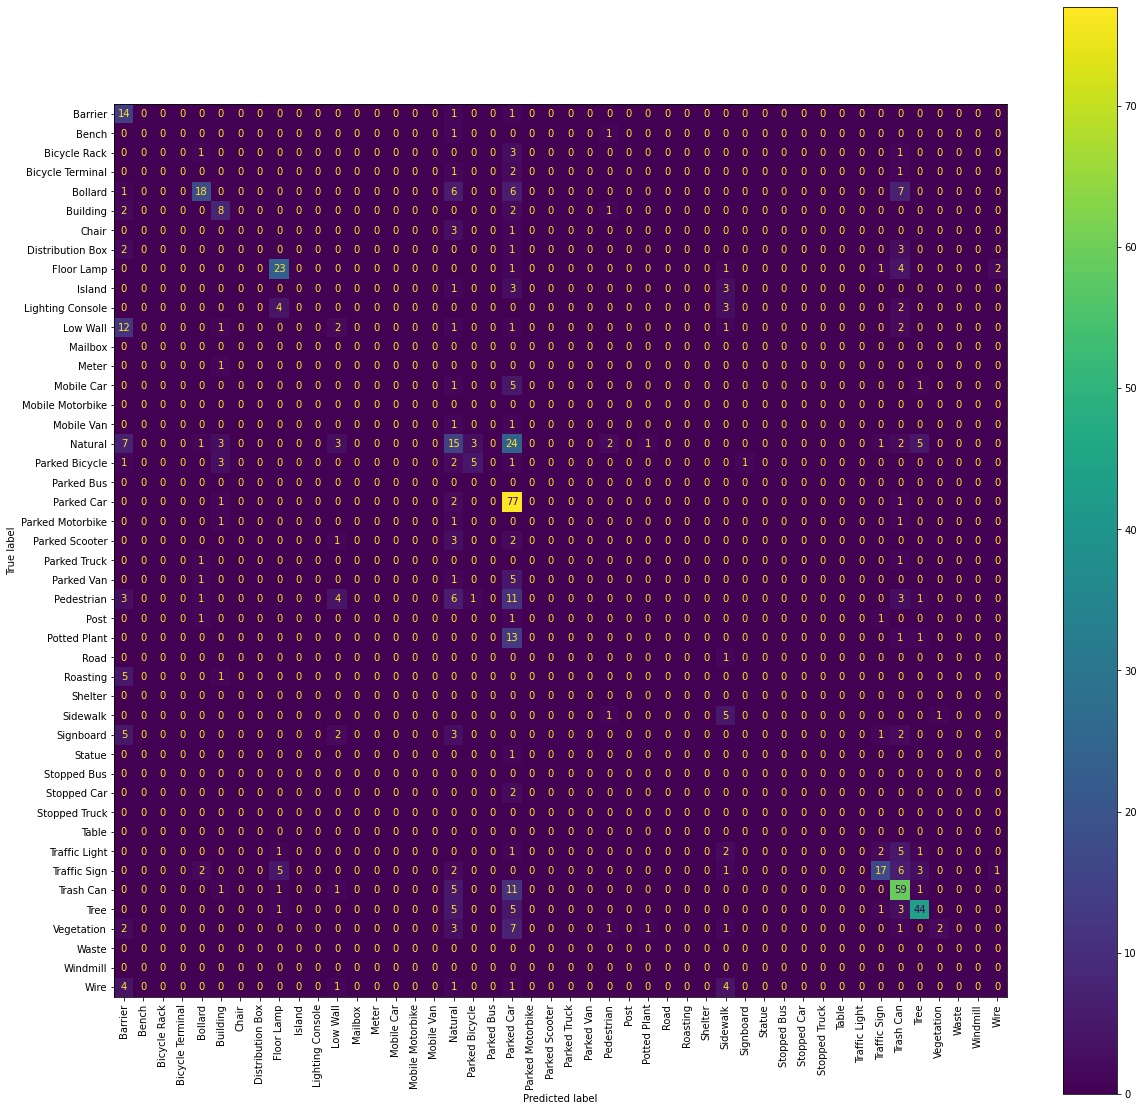

In [44]:
cm = confusion_matrix(ytestlabels, predlabels, unique_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cmd.plot(ax=ax, xticks_rotation='vertical');

plt.savefig('confusionmatrix_pointnet.png', dpi=600)